In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import jellyfish
import textdistance
import sklearn
from sklearn.metrics import precision_recall_fscore_support as pr
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics

In [ ]:
# STEPS

# Step 1. Create a train dataset
# Take a subset of the am20top dataset
# Here, I manually coded if the firms are the same or not. These values are in 'same_firm' column

# Step 2. Create a test dataset
# The full sample of am20top is the test dataset

# Step 3. Split the data on train and validation samples

# Step 4. Evaluate how text similarity measurements predict the outcome

# Step 4. Run a few models on train df

# Step 5. Choose the best model and run it on test df

## Step 1. Create a train dataset

In [3]:
train = pd.read_csv('/datastore0/shared/diliara/Tobias Name Matching/data/df_subset.csv')

In [4]:
train.head() # here how it looks like

# NOTE: Here I assigned 1 and 0 to 'same_firm' only if the name starts with the similar name
# We might want to assign these 1 and 0 based on expert knowledge

,firmName,subsName,same_firm
0,"BLACKROCK, INC",BLACK ROCK,1.0
1,"BLACKROCK, INC",BLACK ROCK,1.0
2,"BLACKROCK, INC",BLACK ROCK INVESTMENT MANAGEMENT KOREA LIMITED,1.0
3,"BLACKROCK, INC",BLACK ROCK INVESTMENTS,1.0
4,"BLACKROCK, INC",BLACK ROCK INVESTMENTS,1.0


In [5]:
# Drop duplicate rows, leave the first occurence
train.drop_duplicates(subset=['firmName', 'subsName'], keep='first', inplace=True)

# Drop NA cases
train = train.dropna(subset=['firmName', 'subsName'], inplace=False)

In [6]:
len(train) # number of rows

1802

In [7]:
# Calculate distances between text entries: firm name and subsidiary name
# Below are different text distance measurements


# Levenshtein Distance

def distance(x):
    return jellyfish.levenshtein_distance(*x)

from multiprocessing import Pool
with Pool() as pool:
    train["leven"] =  pool.map(distance,zip(train["firmName"], train["subsName"]))

# Jaro

def distance(x):
    return jellyfish.jaro_distance(*x)

from multiprocessing import Pool
with Pool() as pool:
    train["jaro"] = pool.map(distance,zip(train["firmName"], train["subsName"]))
    
# Jaro-Winkler

def distance(x):
    return jellyfish.jaro_winkler(*x)

from multiprocessing import Pool
with Pool() as pool:
    train["jaro_winkler"] = pool.map(distance,zip(train["firmName"], train["subsName"]))

# Match Rating Approach Comparison

def distance(x):
    return jellyfish.match_rating_comparison(*x)

from multiprocessing import Pool
with Pool() as pool:
    train["mrc"] = pool.map(distance,zip(train["firmName"], train["subsName"]))
    
# Hamming

def distance(x):
    return jellyfish.hamming_distance(*x)

from multiprocessing import Pool
with Pool() as pool:
    train["hamming"] = pool.map(distance,zip(train["firmName"], train["subsName"]))
    
# Jaccard index

def distance(x):
    return textdistance.jaccard(*x)

from multiprocessing import Pool
with Pool() as pool:
    train["jaccard"] = pool.map(distance,zip(train["firmName"], train["subsName"]))
    
    
# Sørensen index or dice’s coefficient

def distance(x):
    return textdistance.sorensen_dice(*x)

from multiprocessing import Pool
with Pool() as pool:
    train["sordice"] = pool.map(distance,zip(train["firmName"], train["subsName"]))
    
    
# Tversky

def distance(x):
    return textdistance.tversky(*x)

from multiprocessing import Pool
with Pool() as pool:
    train["tversky"] = pool.map(distance,zip(train["firmName"], train["subsName"]))
    
    
# Cosine

def distance(x):
    return textdistance.cosine(*x)

from multiprocessing import Pool
with Pool() as pool:
    train["cosine"] = pool.map(distance,zip(train["firmName"], train["subsName"]))
    

In [8]:
train.head()

,firmName,subsName,same_firm,leven,jaro,jaro_winkler,mrc,hamming,jaccard,sordice,tversky,cosine
0,"BLACKROCK, INC",BLACK ROCK,1.0,6,0.838095,0.902857,True,9,0.714286,0.833333,0.714286,0.845154
2,"BLACKROCK, INC",BLACK ROCK INVESTMENT MANAGEMENT KOREA LIMITED,1.0,35,0.650449,0.650449,True,38,0.250000,0.400000,0.250000,0.472866
3,"BLACKROCK, INC",BLACK ROCK INVESTMENTS,1.0,11,0.745310,0.847186,True,14,0.500000,0.666667,0.500000,0.683763
5,"BLACKROCK, INC",BLACK ROCK INVESTMENTS LLC,1.0,14,0.758242,0.854945,True,18,0.481481,0.650000,0.481481,0.681385
6,"BLACKROCK, INC",BLACK ROCK REALTY,1.0,8,0.700840,0.820504,True,11,0.476190,0.645161,0.476190,0.648204


In [9]:
# Show some random Blackrock subsidiary
train.loc[train['subsName'] == 'BLACKROCK ADVISORS LLC']

# Predicts high, especially Jaro-based distances

,firmName,subsName,same_firm,leven,jaro,jaro_winkler,mrc,hamming,jaccard,sordice,tversky,cosine
27,"BLACKROCK, INC",BLACKROCK ADVISORS LLC,1.0,11,0.800866,0.880519,True,13,0.5,0.666667,0.5,0.683763


## Step 2. Create a test dataset

In [ ]:
# All other datasets are test datasets

In [10]:
# Read each Excel sheet from the am_top20 file
sheet_to_df_map = pd.read_excel('/datastore0/shared/diliara/Tobias Name Matching/data/am_top20.xlsx', sheet_name=None)

# Merge them into one dataset
test = pd.concat(sheet_to_df_map, axis=0, ignore_index=True)

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [11]:
# Take only necessary columns
test = test[['GUO - Name', 'Subsidiary - Name']]

# Rename columns
test.rename(columns={"GUO - Name": "firmName", 'Subsidiary - Name': 'subsName'}, inplace = True)

# Drop duplicates
test.drop_duplicates(subset=['firmName', 'subsName'], keep='first', inplace=True)

# Drop missings
test = test.dropna(subset=['firmName', 'subsName'], inplace=False)

In [15]:
len(test) # length (number of rows)

20771

In [16]:
test.head()

,firmName,subsName
1,"GOLDMAN SACHS GROUP, INC",ARCHON INTERNATIONAL INC
2,"GOLDMAN SACHS GROUP, INC",GOLDMAN SACHS REALTY MANAGEMENT EUROPE GMBH
3,"GOLDMAN SACHS GROUP, INC",ARCHON GROUP ITALIA S.R.L. IN LIQUIDAZIONE
4,"GOLDMAN SACHS GROUP, INC",SGC S.R.L. SOCIETA GESTIONE CREDITI
5,"GOLDMAN SACHS GROUP, INC",COMERCIALIZADORA INTERNACIONAL COLOMBIAN NATUR...


In [17]:
# Also calculate text distances

# Levenshtein Distance

def distance(x):
    return jellyfish.levenshtein_distance(*x)

from multiprocessing import Pool
with Pool() as pool:
    test["leven"] =  pool.map(distance,zip(test["firmName"], test["subsName"]))

# Jaro

def distance(x):
    return jellyfish.jaro_distance(*x)

from multiprocessing import Pool
with Pool() as pool:
    test["jaro"] = pool.map(distance,zip(test["firmName"], test["subsName"]))
    
# Jaro-Winkler

def distance(x):
    return jellyfish.jaro_winkler(*x)

from multiprocessing import Pool
with Pool() as pool:
    test["jaro_winkler"] = pool.map(distance,zip(test["firmName"], test["subsName"]))

# Match Rating Approach Comparison

def distance(x):
    return jellyfish.match_rating_comparison(*x)

from multiprocessing import Pool
with Pool() as pool:
    test["mrc"] = pool.map(distance,zip(test["firmName"], test["subsName"]))
    
# Hamming

def distance(x):
    return jellyfish.hamming_distance(*x)

from multiprocessing import Pool
with Pool() as pool:
    test["hamming"] = pool.map(distance,zip(test["firmName"], test["subsName"]))
    
# Jaccard index

def distance(x):
    return textdistance.jaccard(*x)

from multiprocessing import Pool
with Pool() as pool:
    test["jaccard"] = pool.map(distance,zip(test["firmName"], test["subsName"]))
    
    
# Sørensen index or dice’s coefficient

def distance(x):
    return textdistance.sorensen_dice(*x)

from multiprocessing import Pool
with Pool() as pool:
    test["sordice"] = pool.map(distance,zip(test["firmName"], test["subsName"]))
    
    
# Tversky

def distance(x):
    return textdistance.tversky(*x)

from multiprocessing import Pool
with Pool() as pool:
    test["tversky"] = pool.map(distance,zip(test["firmName"], test["subsName"]))

# Cosine

def distance(x):
    return textdistance.cosine(*x)

from multiprocessing import Pool
with Pool() as pool:
    test["cosine"] = pool.map(distance,zip(test["firmName"], test["subsName"]))

In [18]:
# Assign 1 if there is an exact matching of firm names

test['same_firm'] = test['firmName'] == test['subsName']
test['same_firm'].value_counts()

False    20769
True         2
Name: same_firm, dtype: int64

## Step 3. Split on train and validation samples

In [19]:
# Split datasets on train and validation

feature_names = ['leven', 'jaro', 'jaro_winkler',
       'hamming', 'jaccard', 'sordice', 'tversky', 'cosine']

train_size = int(0.9*len(train)) # train df
val_size = len(train) - train_size # validation df

X_train = train[feature_names].values.astype(float)[:train_size]
df_val = train[-val_size:]

X_val = df_val[feature_names].values.astype(float)
X_test = test[feature_names].values.astype(float)

print(len(X_train), len(X_val), len(X_test))

# Ideally, the test df should be much larger => Re-do this

1621 181 20771


In [20]:
y_train = train.same_firm.values[:train_size]
y_val = train.same_firm.values[-val_size:]
y_test = test.same_firm.values

# Y's are 1 and 0's: same firm or not
# X's are features (text similarity measurements)

## Step 4. Evaluate how text similarity measurements predict the outcome

leven


/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


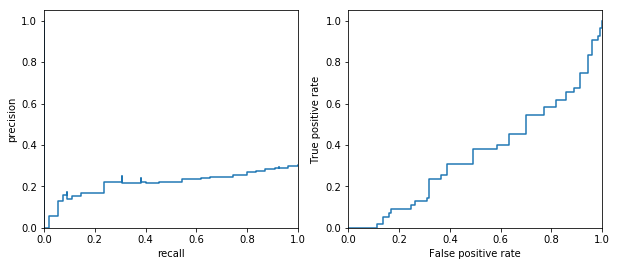


jaro


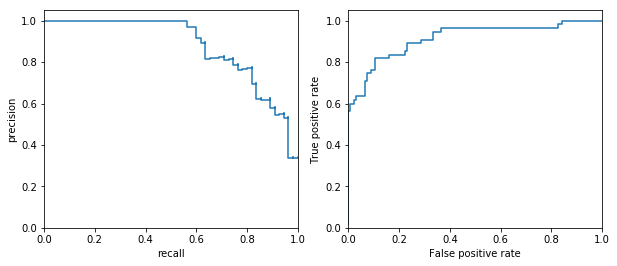


jaro_winkler


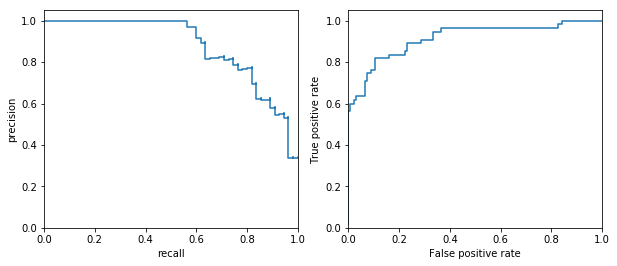


hamming


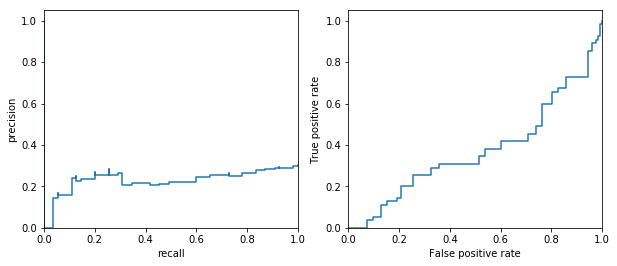


jaccard


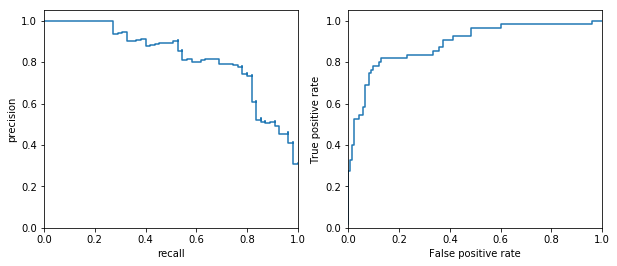


sordice


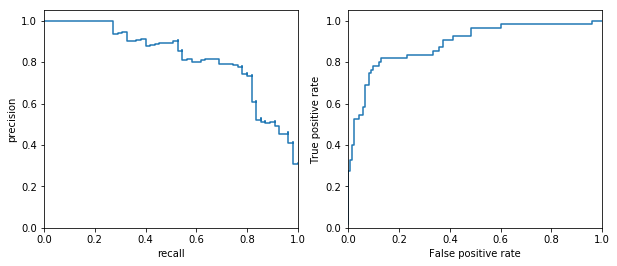


tversky


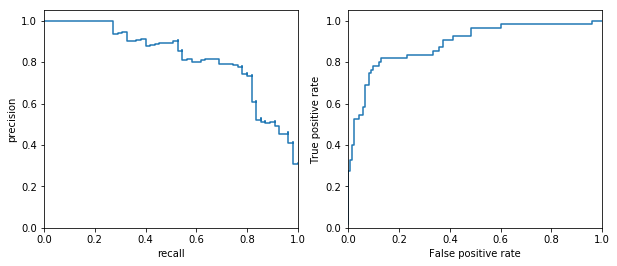


cosine


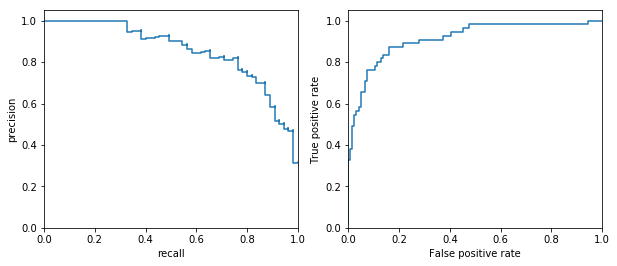

In [21]:
# Show Precision/Recall plots for each text measurement

def evaluate(y_true, y_pred):
    y_true = np.array(y_true) #true values
    y_pred = np.array(y_pred) #predicted values

    prec, rec, thres = sklearn.metrics.precision_recall_curve(y_true, y_pred)
    f1 = 2 * (prec * rec) / (prec + rec)
    df_thresholds = pd.DataFrame({'precision': prec, 'recall': rec, 'threshold':list(thres)+[1], 'f1': f1})
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.step(rec, prec)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1.05)
    ax1.set_xlabel('recall')
    ax1.set_ylabel('precision')
    
    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_pred)
    ax2.step(fpr, tpr)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1.05)
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    
    plt.show()
    
    results = dict(df_thresholds.loc[df_thresholds.f1.idxmax(),:])
    results['AUC'] = sklearn.metrics.roc_auc_score(y_true, y_pred)
    return results

results = {}
for metric in feature_names:
    print(metric)
    results[metric] = evaluate(y_val, df_val[metric])
    print()

## Step 4. Run a few models on train df

In [22]:
models = {}

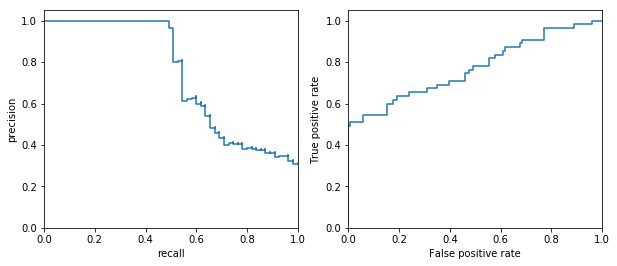

In [23]:
# Support Vector Machine
from sklearn.svm import LinearSVC

clf = sklearn.svm.LinearSVC()
clf.fit(X_train, y_train)
y_pred_val = clf.decision_function(X_val)
results['SVM'] = evaluate(y_val, y_pred_val)
models['SVM'] = clf

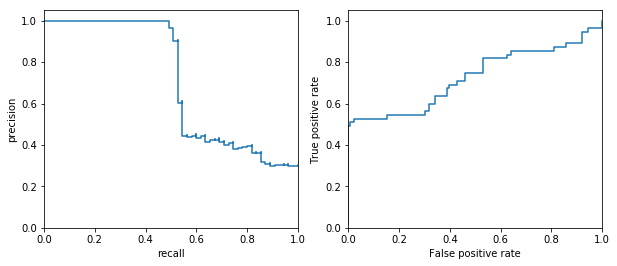

In [24]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

clf = sklearn.linear_model.LogisticRegression()
clf.fit(X_train, y_train)
y_pred_val = clf.predict_proba(X_val)[:,1]
results['LogReg'] = evaluate(y_val, y_pred_val)
models['LogReg'] = clf


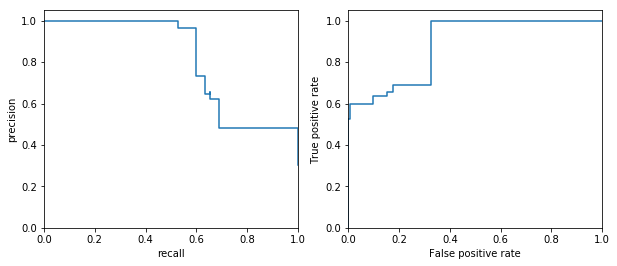

In [25]:
# Random Forest

import sklearn.ensemble
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_val = clf.predict_proba(X_val)[:,1]
results['RandomForest'] = evaluate(y_val, y_pred_val)
models['RandomForest'] = clf


In [26]:
# Show the best model
pd.DataFrame.from_dict(results, orient='index').sort_values('f1', ascending=False)

# Jaro-based models are in general good for this type of data
# Among machine learning approaches,Random Forest works well

,AUC,threshold,precision,f1,recall
jaro,0.914719,0.582206,0.775862,0.796460,0.818182
jaro_winkler,0.914719,0.582206,0.775862,0.796460,0.818182
cosine,0.912554,0.566394,0.823529,0.792453,0.763636
jaccard,0.888889,0.355556,0.781818,0.781818,0.781818
sordice,0.888889,0.524590,0.781818,0.781818,0.781818
tversky,0.888889,0.355556,0.781818,0.781818,0.781818
RandomForest,0.776190,0.900000,0.916667,0.725275,0.600000
LogReg,0.725541,0.756852,0.965517,0.666667,0.509091
SVM,0.771717,0.534724,0.965517,0.666667,0.509091
hamming,0.361616,2.000000,0.303867,0.466102,1.000000


## Step 5. Choose the best model and run on test df

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


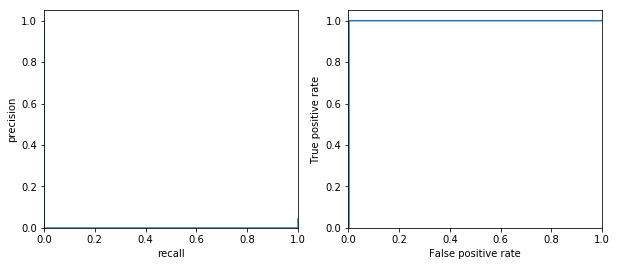

In [27]:
# Estimate the best model on test df
clf = models['LogReg']
y_pred_test = clf.predict_proba(X_test)[:,1]
evaluate(y_test, y_pred_test)

# Assign predicted values as a column to test df:
test['y_pred_test'] = y_pred_test.tolist()

In [28]:
# Explore thresholds

y_true_val = test.same_firm * 1.0
y_pred_val = test.y_pred_test

prec, rec, thres = sklearn.metrics.precision_recall_curve(y_true_val, y_pred_val)
f1 = 2 * (prec * rec) / (prec + rec)
df_thresholds = pd.DataFrame({'precision': prec, 'recall': rec, 'threshold':list(thres)+[1], 'f1': f1})
df_thresholds.head()

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


,f1,precision,recall,threshold
0,0.081633,0.042553,1.0,0.997232
1,NaN,0.000000,0.0,0.997287
2,NaN,0.000000,0.0,0.997355
3,NaN,0.000000,0.0,0.997422
4,NaN,0.000000,0.0,0.997552


In [29]:
# What is the highest f1 value?
df_thresholds.loc[df_thresholds.f1.idxmax(),:]

f1           0.081633
precision    0.042553
recall       1.000000
threshold    0.997232
Name: 0, dtype: float64

In [30]:
# For the threshold with highest f1 values, what mistakes does it make?
t = df_thresholds.loc[df_thresholds.f1.idxmax(),'threshold']
test[(y_true_val!=1*(y_pred_val>=t)) & (test.firmName!=test.subsName)]

# Predicts very well

,firmName,subsName,leven,jaro,jaro_winkler,mrc,hamming,jaccard,sordice,tversky,cosine,same_firm,y_pred_test
10896,MORGAN STANLEY,MORGAN STANLEY CAPITAL PARTNERS V OFFSHORE EMP...,52,0.737374,0.842424,True,52,0.212121,0.350000,0.212121,0.460566,False,0.997552
10961,MORGAN STANLEY,MORGAN STANLEY INFRASTRUCTURE PARTNERS A CHICA...,52,0.737374,0.842424,True,52,0.212121,0.350000,0.212121,0.460566,False,0.997552
11098,MORGAN STANLEY,MORGAN STANLEY DEVELOPED COUNTRIES HIGH INTERE...,60,0.729730,0.837838,True,60,0.189189,0.318182,0.189189,0.434959,False,0.998017
11099,MORGAN STANLEY,MORGAN STANLEY EMERGING COUNTRIES HIGH INTERES...,59,0.730594,0.838356,True,59,0.191781,0.321839,0.191781,0.437928,False,0.997963
11100,MORGAN STANLEY,MORGAN STANLEY HIGH INTEREST RATE CURRENCY FUN...,56,0.733333,0.840000,True,56,0.200000,0.333333,0.200000,0.447214,False,0.997795
11101,MORGAN STANLEY,MORGAN STANLEY HIGH INTEREST RATE CURRENCY FUN...,60,0.729730,0.837838,True,60,0.189189,0.318182,0.189189,0.434959,False,0.998017
11555,MORGAN STANLEY,MORGAN STANLEY ALPHA INSTITUTIONAL CAYMAN FUND...,71,0.721569,0.832941,True,71,0.164706,0.282828,0.164706,0.405840,False,0.998529
11615,MORGAN STANLEY,MORGAN STANLEY AIP FALCONER GLOBAL EX-U.S. REA...,55,0.734300,0.840580,True,55,0.202899,0.337349,0.202899,0.450443,False,0.997736
11625,MORGAN STANLEY,MORGAN STANLEY OPPORTUNISTIC CAYMAN FUND SPC -...,71,0.721569,0.832941,True,71,0.164706,0.282828,0.164706,0.405840,False,0.998529
11626,MORGAN STANLEY,MORGAN STANLEY OPPORTUNISTIC FUND - RETIREMENT...,52,0.737374,0.842424,True,52,0.212121,0.350000,0.212121,0.460566,False,0.997552


In [ ]:
# If 'y_pred_test' > 0.65-0.70, usually it's the same firm

In [33]:
# Save the dataset with predicted values
test.to_csv('df_with_predicted_values.csv')